## Advection equation using SBP Operators

Let us solve the one-dimensional advection equation with periodic boundary conditions
$$
u_t + c u_x = 0\;\; \text{on }[a,b], \\
c>0, \\
u(x,0)=u_0(x), \\
u(a,t)=u(b,t).
$$

Importing some libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from basis_nodes import generate_lagrange_poly, generate_LGL_points
from SBP_matrices import first_order_D, first_order_P_Q

Defining parameters

In [2]:
## Computational domain
#Each element i will be enclosed by x_{i} and x_{i+1}
n_elements = 20
x = np.linspace(0,3*np.pi,n_elements+1)

#Advection speed
c = 1.
#Spatial order of accuracy
order_x = 20

Computing nodes at reference element

In [3]:
#We'll need a Lagrange basis of degree order_x-1
#Thus, we will need order_x nodes in each element
degree_basis = order_x-1
if degree_basis >0:
    (_, _,
    _, _,
    _, _,
    xi_LGL_unsorted, w_LGL_unsorted) = generate_LGL_points(degree_basis)
else:
    xi_LGL_unsorted, w_LGL_unsorted = np.array([0.]), np.array([1.])

#######################
#######################
#The root finder returns unsorted roots,
#We fix that in these lines

#Indexes that would sort x_LG using value
sort_idxs_LGL = np.argsort(xi_LGL_unsorted)
#Sorting x_LG and w_LG using those indexes
xi_LGL = xi_LGL_unsorted[sort_idxs_LGL]
w_LGL = w_LGL_unsorted[sort_idxs_LGL]
#######################
#######################

n_nodes = len(xi_LGL)

Mapping reference element to whole grid. The interface points are stored twice for simplicity.

In [4]:
#We map the nodes from the reference element to one of the elements 
#from our computational domain (this suffices since we are using an uniform grid)
x_min = x[0]
x_max = x[1]

#We just need to map the LGL nodes once since we are using a uniform grid
x_element = (xi_LGL*(x_max-x_min)+(x_min+x_max))/2
w_element = (x_max-x_min)*w_LGL
list_elements = [x_element]

#We define our grid (interface points will be repeated)
x_grid = np.zeros(n_elements*n_nodes)
print(f"Numerical grid with double interface nodes")
for i in range(n_elements): 
    j = i*n_nodes
    x_grid[j:j+n_nodes] = x_element+x[i]
    list_elements.append(x_grid[j:j+n_nodes])
    #print(f"Element {i+1:}\t {x_grid[j:j+n_nodes]}")


Numerical grid with double interface nodes


Setting initial conditions:
$
u(x,0) = \exp\left({-5(x-\pi)^2}\right)%\sin(x).
$

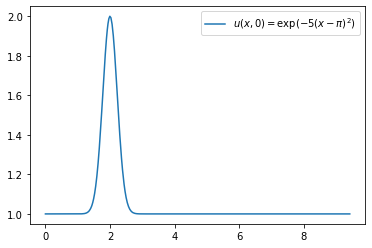

In [5]:
#u = np.sin(x_grid)
initial_c = lambda x: np.exp(-10*(x-2)**2)+1
u0 = initial_c(x_grid)
u = np.copy(u0)
n_grid = len(u)
plt.plot(x_grid,u0, label='$u(x,0)=\exp({-5(x-\pi)^2})$')
plt.legend()
plt.show() 
plt.close()

Obtaining local relevant SBP operators and resizing them over the whole grid with Kronecker products

In [6]:
#Local opretaros P and Q
P_LGL, Q_LGL = first_order_P_Q(x_Lagrange_nodes=x_element, x_abcissae=x_element, w_abcissae=w_element)

#Global operators P and Q
P = np.kron(np.eye(n_elements), P_LGL)
Q = np.kron(np.eye(n_elements), Q_LGL)

#Restriction operators R, B
#Local
R_LGL = np.zeros((2,n_nodes))
R_LGL[0,0] = R_LGL[-1,-1] = 1
B_LGL = np.zeros((2,2))
B_LGL[0,0] = -1; B_LGL[-1,-1]=1
#Global
R = np.kron(np.eye(n_elements), R_LGL)
B = np.kron(np.eye(n_elements), B_LGL)


#Differential operator D
#Local
D_LGL = first_order_D(x_nodes=x_element)
#Global
D = np.kron(np.eye(n_elements), D_LGL)

#Numerical flux
#Local
#f_num_loc = lambda uL, uR : c*(uL+uR)/2 #Centered flux
f_num_loc = lambda uL, uR : c*uL #Upwind flux
#Global
#Global
def f_num(u,n_elements=n_elements,n_nodes=n_nodes):
    #Computing numerical flux just at the interface of elements
    #Fill numerical flux vector for first element
    
    if n_elements == 1:
        f = [c*u[-1], c*u[-1]]    #The first component should be c*source at the left
                            #Here the source is g(t)=1
        return np.array(f)
    
    #For general periodic BCs
    f = [c*u[-1],         #Left interface
             c*u[n_nodes-1]]  #Right interface
    for idx_elem in range(1,n_elements-1):
        #Left interface
        idx_R = idx_elem*n_nodes
        idx_L = idx_R-1
        f.append(f_num_loc(u[idx_L],u[idx_R]))
        #print(f"Element {idx_elem+1}")
        #print(f"Left interface")
        #print(f"{idx_L, idx_R}")
        #Right interface
        idx_R = (idx_elem+1)*n_nodes
        idx_L = idx_R-1
        f.append(f_num_loc(u[idx_L],u[idx_R]))
        #print(f"Right interface")
        #print(f"{idx_L, idx_R}")
        
    #Fill numerical flux vector for last element
    f.append(c*u[-n_nodes-1]) #Left interface
    f.append(c*u[-1])       #Right interface
        #print(f"Last element")
        #print(f"Left interface")
        #print(f"{-n_nodes-1, -n_nodes}")
        #print(f"Right interface")
        #print(f"{n_nodes*n_elements-1, 0}")
    return np.array(f)


#Vector and matrix with advection speed
c_vec = c*np.ones_like(u)
c_mat = c*np.eye(len(u))


def print_matrix(P):
    for i in range(len(P[0])):
        for j in range(len(P)):
            print(np.round(P[i,j],1),end=' ')
        print("")
    return None

/Users/munozmca/Desktop/Courses/Spring_2023/SBP_Operators_AMCS348/basis_nodes.py:21: RuntimeWarning: invalid value encountered in divide
  return np.prod((x-x_nodes)/(xj-x_nodes), where = mask)
/Users/munozmca/Desktop/Courses/Spring_2023/SBP_Operators_AMCS348/basis_nodes.py:21: RuntimeWarning: divide by zero encountered in divide
  return np.prod((x-x_nodes)/(xj-x_nodes), where = mask)


Debugging cell:

In [7]:
#We define our grid (interface points will be repeated)
x_grid = np.zeros(n_elements*n_nodes)
for i in range(n_elements): 
    j = i*n_nodes
    x_grid[j:j+n_nodes] = x_element+x[i]
    #print(f"Element {i+1:}\t {j}   {j+n_nodes-1}")

Debugging cell:

In [8]:
f=f_num(u=u,n_elements=n_elements,n_nodes=n_nodes)
len(f)

40

Defining semi-discrete RHS operator

In [9]:
def RHS(u):
    split_form_interior = -0.5*D@c_mat@u -0.5*c_mat@D@u -0.5*np.diag(u)@D@c_vec
    elem_boundary_terms = -np.linalg.inv(P)@R.T@B@(f_num(u=u)-c*R@u)
    #elem_boundary_terms = np.linalg.inv(P)@R.T@B@(f_num(u=u)+c*R@u)

    #print(np.max(f_num(u=u)-c*R@u))
    return split_form_interior+elem_boundary_terms

def RHS_w_time(t,u):
    split_form_interior = -0.5*D@c_mat@u -0.5*c_mat@D@u -0.5*np.diag(u)@D@c_vec
    elem_boundary_terms = -np.linalg.inv(P)@R.T@B@(f_num(u=u)-c*R@u)
    #elem_boundary_terms = np.linalg.inv(P)@R.T@B@(f_num(u=u)+c*R@u)

    #print(np.max(f_num(u=u)-c*R@u))
    return split_form_interior+elem_boundary_terms

Plotting the solution

In [10]:
from matplotlib.animation import FuncAnimation

def plotting_sol(u_frames,x_grid, t_eval, plotexact):
    # Set up the figure and axis
    fig, ax = plt.subplots(dpi=200, figsize=[8,4])
    ax.set_xlim(x_grid.min(), x_grid.max())
    minu = u_frames[0].min()
    maxu = u_frames[0].max()
    margin = 0.5
    ax.set_ylim(minu-margin*min(np.abs(minu),1.), maxu+margin*max(np.abs(maxu),1.))
    line_approx, = ax.plot(x_grid,u_frames[0], label= "SBP solution")#ax.plot([], [])
    
    u_exact = np.array([initial_c(x_grid-c*time) for time in t_eval]) 
    dx = x_grid[1]-x_grid[0]
    u0 = u_frames[0]
    if plotexact:
        line_exact, = ax.plot(x_grid,u_exact[0], linestyle='dotted', color='r', label="exact solution")
    

    def animate(i):
        u_approx = u_frames[i]
        line_approx.set_data(x_grid, u_approx)
        mass = np.round(np.linalg.norm(u_approx,ord=1)*dx,2)
        error = np.round(np.linalg.norm(u_exact[i]-u_approx, ord=2)*np.sqrt(dx),4)
        ax.set_title(f"Time: {np.round(t_eval[i])}    ||   Mass={mass}    ||    Error={error}")
        #line_approx.set_label("SBP solution")
        if plotexact:
            line_exact.set_data(x_grid, u_exact[i])
            #line_exact.set_label("exact solution")
            return line_approx, line_exact
        else:
            return line_approx,

    import matplotlib
    from matplotlib import animation
    from IPython.display import HTML
    anim = FuncAnimation(fig, animate,
                                       frames=len(u_frames),
                                       interval=200,
                                       repeat=False)
    plt.legend()
    plt.close()
    return HTML(anim.to_jshtml())
#plotting_sol(u_frames,x_grid)

## Time Integration
We use Strong Stability Preserving RK schemes as described in Gottlieb et al. (2011).

In [11]:
import SSPRK
t0 = 0.
tfinal = 5.
dx = np.min(np.diff(x_grid[:n_nodes]))
CFL = 0.1
dt = CFL*c*dx
nframes = 50
u_frames, t_eval = SSPRK.SSPRK33(fun=RHS, u0=u0, dt=dt, t0=t0, tfinal=tfinal, nframes=nframes)

Plotting solution

In [12]:
plotting_sol(u_frames,x_grid, t_eval, plotexact=True)

In [13]:
from nodepy import rk

In [14]:
rkm = rk.ExplicitRungeKuttaMethod(A_Heun,b_Heun)
rkm.plot_stability_region();

NameError: name 'A_Heun' is not defined

In [ ]:
rkm.imaginary_stability_interval()

In [ ]:
rkm.order()

In [ ]:
sum(u_frames[0])

In [ ]:
sum(u_frames[-1])